In [1]:
!pip3 install statsmodels

In [2]:
!pip install yfinance

In [3]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import os
import warnings
warnings.filterwarnings('ignore')


import yfinance as yf
df = yf.download('GOOGL', start='2010-10-10', end='2020-2-20', progress=False)

df.head()

,Open,High,Low,Close,Adj Close,Volume
Date,,,,,,
2010-10-11,269.509521,272.572571,268.853851,269.689697,269.689697,5247347
2010-10-12,270.330322,273.268280,269.164154,270.965973,270.965973,7499693
2010-10-13,273.773773,274.019012,271.436432,271.921936,271.921936,6105089
2010-10-14,272.362366,272.897888,268.823822,270.735748,270.735748,13254932
2010-10-15,299.934937,301.121124,296.096100,301.026031,301.026031,29619950


In [25]:
df.shape

(2355, 6)

In [28]:
df.describe()

,Open,High,Low,Close,Adj Close,Volume
count,2355.000000,2355.000000,2355.000000,2355.000000,2355.000000,2.355000e+03
mean,695.761296,701.494567,689.651333,695.778795,695.778795,3.101049e+06
std,331.276265,334.160139,328.522335,331.540356,331.540356,2.476080e+06
min,237.237244,240.615616,236.746750,237.677673,237.677673,5.206000e+05
25%,389.677185,392.667664,385.763275,389.977478,389.977478,1.505650e+06
50%,601.349976,605.410400,597.127136,601.946960,601.946960,2.250100e+06
75%,998.779999,1007.360016,991.429993,999.904999,999.904999,4.093602e+06
max,1527.199951,1530.739990,1520.979980,1524.869995,1524.869995,2.961995e+07


In [29]:
df.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 2355 entries, 2010-10-11 to 2020-02-19
Data columns (total 6 columns):
 #   Column     Non-Null Count  Dtype  
---  ------     --------------  -----  
 0   Open       2355 non-null   float64
 1   High       2355 non-null   float64
 2   Low        2355 non-null   float64
 3   Close      2355 non-null   float64
 4   Adj Close  2355 non-null   float64
 5   Volume     2355 non-null   int64  
dtypes: float64(5), int64(1)
memory usage: 128.8 KB


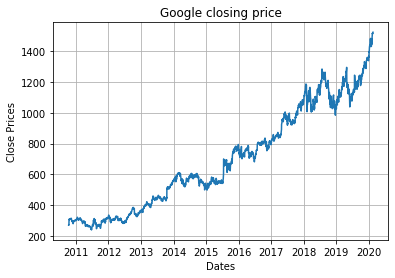

In [4]:
plt.grid(True)
plt.xlabel('Dates')
plt.ylabel('Close Prices')
plt.plot(df['Close'])
plt.title('Google closing price')
plt.show()

**TIME SERIES FORECAST USING FBPROHET**

In [5]:
data = df.reset_index()
data = data[["Date","Close"]]
data = data.rename(columns = {"Date":"ds","Close":"y"})
data.head(5)

,ds,y
0,2010-10-11,269.689697
1,2010-10-12,270.965973
2,2010-10-13,271.921936
3,2010-10-14,270.735748
4,2010-10-15,301.026031


In [6]:
from fbprophet import Prophet
m = Prophet(daily_seasonality = True) # the Prophet class (model)
m.fit(data) # fit the model using all data

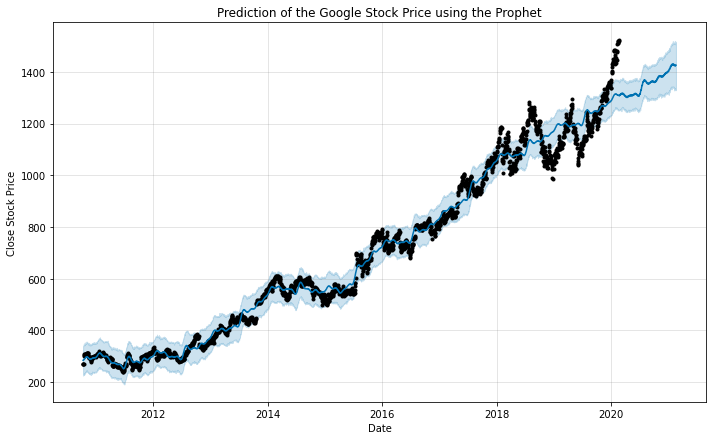

In [7]:
future = m.make_future_dataframe(periods=365) #we need to specify the number of days in future
prediction = m.predict(future)
m.plot(prediction)
plt.title("Prediction of the Google Stock Price using the Prophet")
plt.xlabel("Date")
plt.ylabel("Close Stock Price")
plt.show()

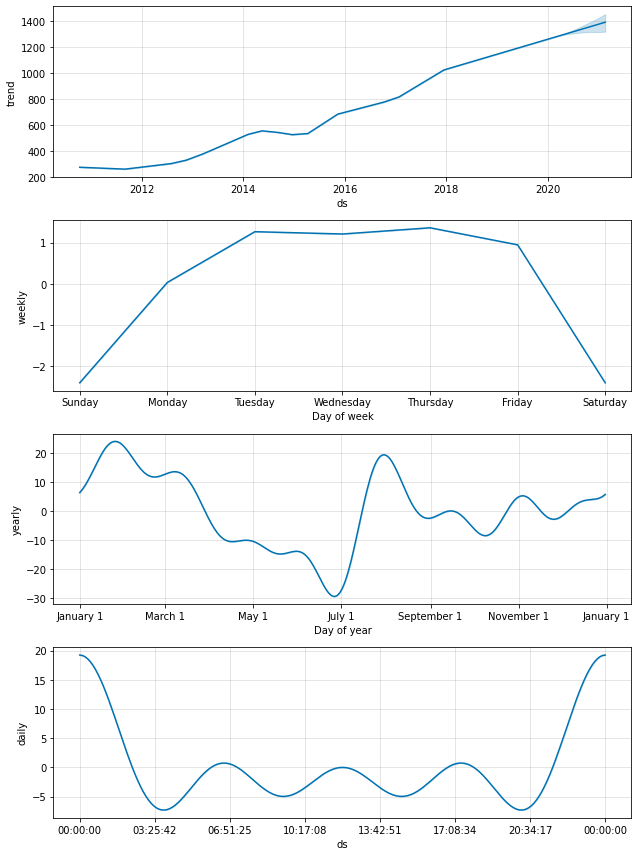

In [8]:
m.plot_components(prediction)
plt.show()

# trend, weekly, yearly, daily components

**ADF Test**

In [9]:
#Ho: It is non-stationary
#H1: It is stationary

In [10]:
#Test for staionarity

from statsmodels.tsa.stattools import adfuller
def test_stationarity(timeseries):
    #Determing rolling statistics
    rolmean = timeseries.rolling(12).mean()
    rolstd = timeseries.rolling(12).std()
    #Plot rolling statistics:
    plt.plot(timeseries, color='blue',label='Original')
    plt.plot(rolmean, color='red', label='Rolling Mean')
    plt.plot(rolstd, color='black', label = 'Rolling Std')
    plt.legend(loc='best')
    plt.title('Rolling Mean and Standard Deviation')
    plt.show(block=False)
    
    print("Results of dickey fuller test")
    adft = adfuller(timeseries,autolag='AIC')
    # output for dft will give us without defining what the values are.
    #hence we manually write what values does it explains using a for loop
    output = pd.Series(adft[0:4],index=['Test Statistics','p-value','No. of lags used','Number of observations used'])
    for key,values in adft[4].items():
        output['critical value (%s)'%key] =  values
    print(output)
    
#test_stationarity(data['Close'])

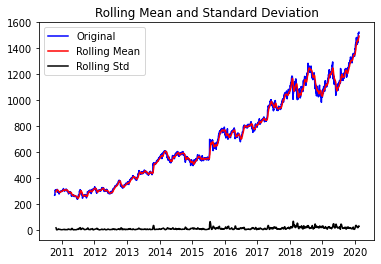

Results of dickey fuller test
Test Statistics                   1.321301
p-value                           0.996726
No. of lags used                 11.000000
Number of observations used    2343.000000
critical value (1%)              -3.433144
critical value (5%)              -2.862774
critical value (10%)             -2.567427
dtype: float64


In [11]:
test_stationarity(df['Close'])

In [12]:
# from statsmodels.tsa.seasonal import seasonal_decompose
# result = seasonal_decompose(df['Close'], model='multiplicative', freq = 30)
# fig = plt.figure()  
# fig = result.plot()  
# fig.set_size_inches(16, 9)

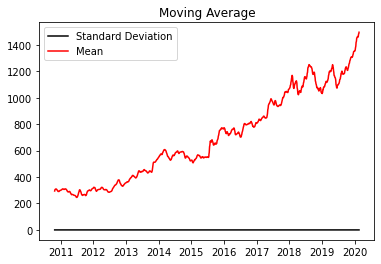

In [13]:
df_log = np.log(df['Close'])
moving_avg = df['Close'].rolling(12).mean()
std_dev = df_log.rolling(12).std()
plt.legend(loc='best')
plt.title('Moving Average')
plt.plot(std_dev, color ="black", label = "Standard Deviation")
plt.plot(moving_avg, color="red", label = "Mean")
plt.legend()
plt.show()

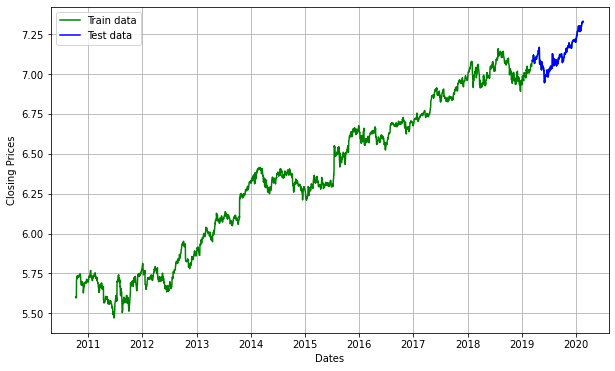

In [14]:
#split data into train and training set
train_data, test_data = df_log[3:int(len(df_log)*0.9)], df_log[int(len(df_log)*0.9):]
plt.figure(figsize=(10,6))
plt.grid(True)
plt.xlabel('Dates')
plt.ylabel('Closing Prices')
plt.plot(df_log, 'green', label='Train data')
plt.plot(test_data, 'blue', label='Test data')
plt.legend()

In [15]:
!pip install pmdarima

In [16]:
from pmdarima.arima import auto_arima

In [17]:
model_autoARIMA = auto_arima(train_data, start_p=0, start_q=0,
                      test='adf',       # use adftest to find             optimal 'd'
                      max_p=3, max_q=3, # maximum p and q
                      m=1,              # frequency of series
                      d=None,           # let model determine 'd'
                      seasonal=False,   # No Seasonality
                      start_P=0, 
                      D=0, 
                      trace=True,
                      error_action='ignore',  
                      suppress_warnings=True, 
                      stepwise=True)
print(model_autoARIMA.summary())

Performing stepwise search to minimize aic
 ARIMA(0,0,0)(0,0,0)[0]             : AIC=13837.922, Time=0.11 sec
 ARIMA(1,0,0)(0,0,0)[0]             : AIC=inf, Time=0.36 sec
 ARIMA(0,0,1)(0,0,0)[0]             : AIC=inf, Time=0.72 sec
 ARIMA(1,0,1)(0,0,0)[0]             : AIC=-11719.080, Time=1.27 sec
 ARIMA(2,0,1)(0,0,0)[0]             : AIC=-11688.347, Time=1.34 sec
 ARIMA(1,0,2)(0,0,0)[0]             : AIC=-11716.924, Time=1.55 sec
 ARIMA(0,0,2)(0,0,0)[0]             : AIC=inf, Time=0.44 sec
 ARIMA(2,0,0)(0,0,0)[0]             : AIC=inf, Time=1.42 sec
 ARIMA(2,0,2)(0,0,0)[0]             : AIC=inf, Time=2.59 sec
 ARIMA(1,0,1)(0,0,0)[0] intercept   : AIC=-11721.628, Time=0.38 sec
 ARIMA(0,0,1)(0,0,0)[0] intercept   : AIC=24.583, Time=0.75 sec
 ARIMA(1,0,0)(0,0,0)[0] intercept   : AIC=inf, Time=0.34 sec
 ARIMA(2,0,1)(0,0,0)[0] intercept   : AIC=-11719.530, Time=0.46 sec
 ARIMA(1,0,2)(0,0,0)[0] intercept   : AIC=-11719.665, Time=0.47 sec
 ARIMA(0,0,0)(0,0,0)[0] intercept   : AIC=2871.423, 

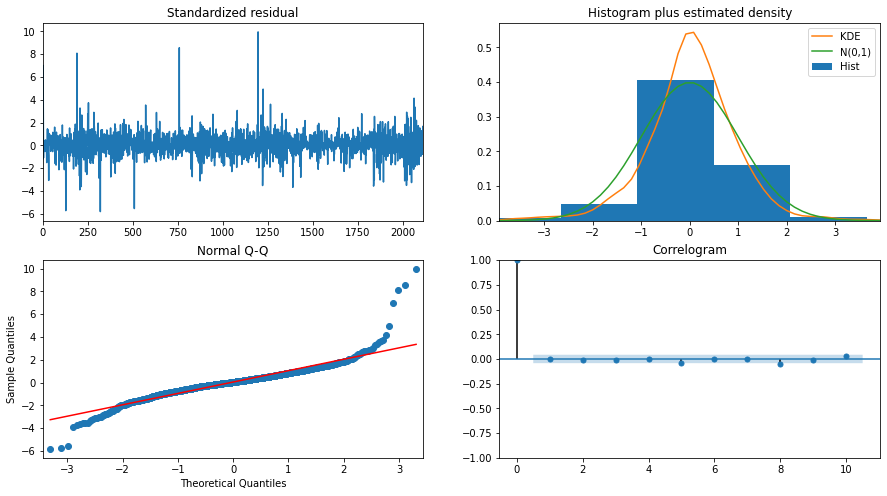

In [18]:
model_autoARIMA.plot_diagnostics(figsize=(15,8))
plt.show()

In [19]:
from statsmodels.tsa.arima.model import ARIMA

In [20]:
m = ARIMA(train_data, order=(1,0, 1))  
fitted = m.fit()  
print(fitted.summary())

/usr/local/lib/python3.7/dist-packages/statsmodels/tsa/base/tsa_model.py:595: ValueWarning:

A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.

/usr/local/lib/python3.7/dist-packages/statsmodels/tsa/base/tsa_model.py:595: ValueWarning:

A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.

/usr/local/lib/python3.7/dist-packages/statsmodels/tsa/base/tsa_model.py:595: ValueWarning:

A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.



                               SARIMAX Results                                
Dep. Variable:                  Close   No. Observations:                 2116
Model:                 ARIMA(1, 0, 1)   Log Likelihood                5864.839
Date:                Wed, 24 Nov 2021   AIC                         -11721.677
Time:                        07:09:15   BIC                         -11699.048
Sample:                             0   HQIC                        -11713.392
                               - 2116                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const          6.3446      0.507     12.523      0.000       5.352       7.338
ar.L1          0.9997      0.001   1518.099      0.000       0.998       1.001
ma.L1          0.0144      0.018      0.790      0.4

In [31]:
predicted = fitted.predict()#start=90,end=103,dynamic=True)
predicted

Date
2010-10-14    6.344622
2010-10-15    5.601372
2010-10-18    5.708920
2010-10-19    5.734424
2010-10-20    5.717707
                ...   
2019-03-07    7.060146
2019-03-08    7.047862
2019-03-11    7.047263
2019-03-12    7.072777
2019-03-13    7.087763
Name: predicted_mean, Length: 2116, dtype: float64

In [22]:
df_log

Date
2010-10-11    5.597272
2010-10-12    5.601993
2010-10-13    5.605515
2010-10-14    5.601143
2010-10-15    5.707197
                ...   
2020-02-12    7.325564
2020-02-13    7.322107
2020-02-14    7.325630
2020-02-18    7.326097
2020-02-19    7.329664
Name: Close, Length: 2355, dtype: float64

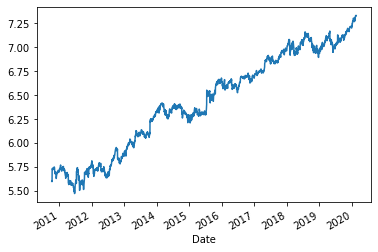

In [23]:
df_log.plot()

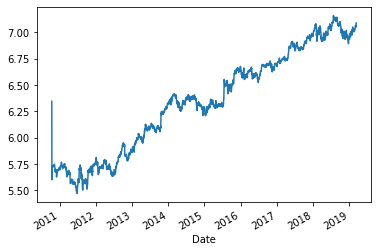

In [24]:
predicted.plot()